In [1]:
import pandas as pd

In [2]:
# Load datasets
case_data = pd.read_csv('PC_case.csv')
control_data = pd.read_csv('PC_control.csv')
gene_data = pd.read_csv('geneList.csv')

In [3]:
case_data.columns = ['Chromosome', 'Start', 'End', 'Type', 'Patient_ID']
control_data.columns = ['Chromosome', 'Start', 'End', 'Type', 'Patient_ID']
gene_data.columns = ['Gene_ID', 'Chromosome_ID', 'Chromosome', 'Gene_Start', 'Gene_End']

In [4]:
# Combine case and control data
case_data['target'] = 1
control_data['target'] = 0
combined_data = pd.concat([case_data, control_data])

In [5]:
# # Map variations to genes
# def map_variations_to_genes(row):
#     gene_match = gene_data[
#         (gene_data['Chromosome_ID'] == row['Chromosome']) &
#         (gene_data['Gene_Start'] <= row['End']) &
#         (gene_data['Gene_End'] >= row['Start'])
#     ]
#     return ','.join(gene_match['Gene_ID'].tolist())

# combined_data['AffectedGenes'] = combined_data.apply(map_variations_to_genes, axis=1)

# Map significant regions to genes
def map_to_genes(region, genes):
    region_chrom = str(region['Chromosome'])
    region_start = region['Start']
    region_end = region['End']
    overlapping_genes = genes[
        (genes['Chromosome'] == f'chr{region_chrom}') &
        (genes['Gene_End'] >= region_start) &
        (genes['Gene_Start'] <= region_end)
    ]
    return ";".join(overlapping_genes['Gene_ID'])

# Apply mapping to each significant region
combined_data['Associated_Genes'] = combined_data.apply(
    lambda row: map_to_genes(row, gene_data), axis=1
)

In [6]:
combined_data

,Chromosome,Start,End,Type,Patient_ID,target,Associated_Genes
0,13,106542688,115109852,dup,SP114986,1,CATG00000016092;CATG00000016093;CATG0000001609...
1,8,90067523,90940205,dup,SP114980,1,CATG00000099728;CATG00000099730;CATG0000009973...
2,13,82892302,94651715,dup,SP114978,1,CATG00000015536;CATG00000015546;CATG0000001554...
3,10,116642982,116959246,del,SP114982,1,CATG00000116507;CATG00000116509;CATG0000011651...
4,1,157319909,157774897,dup,SP114974,1,CATG00000021166;CATG00000021186;CATG0000007872...
...,...,...,...,...,...,...,...
32443,X,2054564,2054564,dup,HG00313,0,
32444,X,2461854,2461854,dup,HG03212,0,
32445,X,154298802,154298802,dup,NA18916,0,
32446,X,77055184,77055184,dup,HG01098,0,


In [7]:
# Export the DataFrame to a CSV file
combined_data.to_csv('combined_data.csv', index=False) # Set index=False to avoid writing row indices to the file

In [8]:
combined_data

,Chromosome,Start,End,Type,Patient_ID,target,Associated_Genes
0,13,106542688,115109852,dup,SP114986,1,CATG00000016092;CATG00000016093;CATG0000001609...
1,8,90067523,90940205,dup,SP114980,1,CATG00000099728;CATG00000099730;CATG0000009973...
2,13,82892302,94651715,dup,SP114978,1,CATG00000015536;CATG00000015546;CATG0000001554...
3,10,116642982,116959246,del,SP114982,1,CATG00000116507;CATG00000116509;CATG0000011651...
4,1,157319909,157774897,dup,SP114974,1,CATG00000021166;CATG00000021186;CATG0000007872...
...,...,...,...,...,...,...,...
32443,X,2054564,2054564,dup,HG00313,0,
32444,X,2461854,2461854,dup,HG03212,0,
32445,X,154298802,154298802,dup,NA18916,0,
32446,X,77055184,77055184,dup,HG01098,0,


In [9]:
# Feature engineering
combined_data['VariationLength'] = combined_data['End'] - combined_data['Start']

In [10]:
combined_data

,Chromosome,Start,End,Type,Patient_ID,target,Associated_Genes,VariationLength
0,13,106542688,115109852,dup,SP114986,1,CATG00000016092;CATG00000016093;CATG0000001609...,8567164
1,8,90067523,90940205,dup,SP114980,1,CATG00000099728;CATG00000099730;CATG0000009973...,872682
2,13,82892302,94651715,dup,SP114978,1,CATG00000015536;CATG00000015546;CATG0000001554...,11759413
3,10,116642982,116959246,del,SP114982,1,CATG00000116507;CATG00000116509;CATG0000011651...,316264
4,1,157319909,157774897,dup,SP114974,1,CATG00000021166;CATG00000021186;CATG0000007872...,454988
...,...,...,...,...,...,...,...,...
32443,X,2054564,2054564,dup,HG00313,0,,0
32444,X,2461854,2461854,dup,HG03212,0,,0
32445,X,154298802,154298802,dup,NA18916,0,,0
32446,X,77055184,77055184,dup,HG01098,0,,0


In [14]:
combined_data_no_patient_id = combined_data.drop(columns=["Patient_ID"])

In [15]:
# One-Hot Encoding
combined_data_encoded = pd.get_dummies(combined_data_no_patient_id, columns=['Chromosome', 'Type', 'Associated_Genes'], drop_first=True)

In [16]:
combined_data_encoded

,Start,End,target,VariationLength,Chromosome_10,Chromosome_11,Chromosome_12,Chromosome_13,Chromosome_14,Chromosome_15,...,Associated_Genes_ENSG00000272917,Associated_Genes_ENSG00000273079,Associated_Genes_ENSG00000273118,Associated_Genes_ENSG00000273145,Associated_Genes_ENSG00000273189,Associated_Genes_ENSG00000273320,Associated_Genes_ENSG00000273329,Associated_Genes_ENSG00000273348,Associated_Genes_ENSG00000273415,Associated_Genes_ENSG00000273492
0,106542688,115109852,1,8567164,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,90067523,90940205,1,872682,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,82892302,94651715,1,11759413,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,116642982,116959246,1,316264,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,157319909,157774897,1,454988,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32443,2054564,2054564,0,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
32444,2461854,2461854,0,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
32445,154298802,154298802,0,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
32446,77055184,77055184,0,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [17]:
# Train a model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [19]:
X = combined_data_encoded.drop(['target'], axis=1) ######################################
y = combined_data_encoded['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [21]:
# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      6475
           1       0.97      0.96      0.97      2328

    accuracy                           0.98      8803
   macro avg       0.98      0.97      0.98      8803
weighted avg       0.98      0.98      0.98      8803



In [22]:
# Feature importance
importances = model.feature_importances_
feature_names = X.columns
important_features = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
important_features.sort_values(by='Importance', ascending=False, inplace=True)

In [28]:
associated_genes_cols

['Associated_Genes_CATG00000000004;CATG00000000085;CATG00000000098;CATG00000000217;CATG00000000254;CATG00000000267;CATG00000000331;CATG00000000442;CATG00000000443;CATG00000000454;CATG00000000533;CATG00000000569;CATG00000000642;CATG00000000666;CATG00000000809;CATG00000000858;CATG00000001007;CATG00000001105;CATG00000001133;CATG00000001175;CATG00000001196;CATG00000001361;CATG00000001383;CATG00000001469;CATG00000001497;CATG00000001586;CATG00000001587;CATG00000001608;CATG00000001614;CATG00000001724;CATG00000001743;CATG00000001837;CATG00000002109;CATG00000002118;CATG00000002243;CATG00000002291;CATG00000002307;CATG00000002314;CATG00000002414;CATG00000002447;CATG00000002449;CATG00000002453;CATG00000002455;CATG00000002476;CATG00000002496;CATG00000002524;CATG00000002591;CATG00000002663;CATG00000002664;CATG00000002667;CATG00000002697;CATG00000002698;CATG00000002744;CATG00000002831;CATG00000002961;CATG00000003023;CATG00000003036;CATG00000003048;CATG00000003052;CATG00000003053;CATG00000003056;CATG0

In [25]:
# Identify significant genes
# Get the list of one-hot encoded columns for Associated_Genes
associated_genes_cols = [col for col in combined_data_encoded.columns if col.startswith('Associated_Genes_')]

# Filter data for target == 1 and sum the one-hot encoded columns
significant_genes = combined_data_encoded[combined_data_encoded['target'] == 1][associated_genes_cols].sum()

# Get the top genes
print("Top cancer-associated genes:", significant_genes.sort_values(ascending=False).head())

Top cancer-associated genes: Associated_Genes_ENSG00000099974;ENSG00000184674;ENSG00000235231                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [26]:
# # Identify significant genes
# significant_genes = combined_data_encoded[combined_data_encoded['target'] == 1]['Associated_Genes'].value_counts()
# print("Top cancer-associated genes:", significant_genes.head())

In [27]:
# Save significant genes to a file
significant_genes.sort_values(ascending=False).to_csv('significant_genes.csv')

In [46]:
signif_genes = pd.read_csv('significant_genes.csv')

In [47]:
signif_genes

,Unnamed: 0,0
0,Associated_Genes_ENSG00000099974;ENSG000001846...,41
1,Associated_Genes_CATG00000097688;CATG000000976...,35
2,Associated_Genes_CATG00000006016;CATG000000060...,30
3,Associated_Genes_ENSG00000110092;ENSG00000149716,21
4,Associated_Genes_CATG00000030399;CATG000000327...,21
...,...,...
21453,Associated_Genes_ENSG00000269793,0
21454,Associated_Genes_ENSG00000269821,0
21455,Associated_Genes_ENSG00000269927,0
21456,Associated_Genes_ENSG00000269957,0


In [49]:
signif_genes.columns = ["significant_genes", "count"]

In [50]:
# prompt: show me the values of significant_genes column of signif_genes

print(signif_genes['significant_genes'].values)

,significant_genes,count
0,Associated_Genes_ENSG00000099974;ENSG000001846...,41
1,Associated_Genes_CATG00000097688;CATG000000976...,35
2,Associated_Genes_CATG00000006016;CATG000000060...,30
3,Associated_Genes_ENSG00000110092;ENSG00000149716,21
4,Associated_Genes_CATG00000030399;CATG000000327...,21
...,...,...
21453,Associated_Genes_ENSG00000269793,0
21454,Associated_Genes_ENSG00000269821,0
21455,Associated_Genes_ENSG00000269927,0
21456,Associated_Genes_ENSG00000269957,0


In [55]:
# Split the genes in the "Unnamed: 0" column by ';', count each gene individually, and sum their occurrences
gene_counts = signif_genes['significant_genes'].str.split(';').explode().value_counts()

# Convert to a DataFrame for better readability
gene_counts_df = gene_counts.reset_index()
gene_counts_df.columns = ['Gene', 'Count']

# Display the resulting gene counts
# import ace_tools as tools; tools.display_dataframe_to_user(name="Gene Counts and Frequencies", dataframe=gene_counts_df)


In [56]:
gene_counts_df

,Gene,Count
0,ENSG00000211899,158
1,ENSG00000211896,156
2,ENSG00000211973,131
3,ENSG00000211967,93
4,ENSG00000226777,84
...,...,...
71170,Associated_Genes_CATG00000029180,1
71171,Associated_Genes_CATG00000028856,1
71172,Associated_Genes_CATG00000028660,1
71173,Associated_Genes_CATG00000028685,1


In [57]:
significant_genes.sort_values(ascending=False).to_csv('signif_genes.csv')

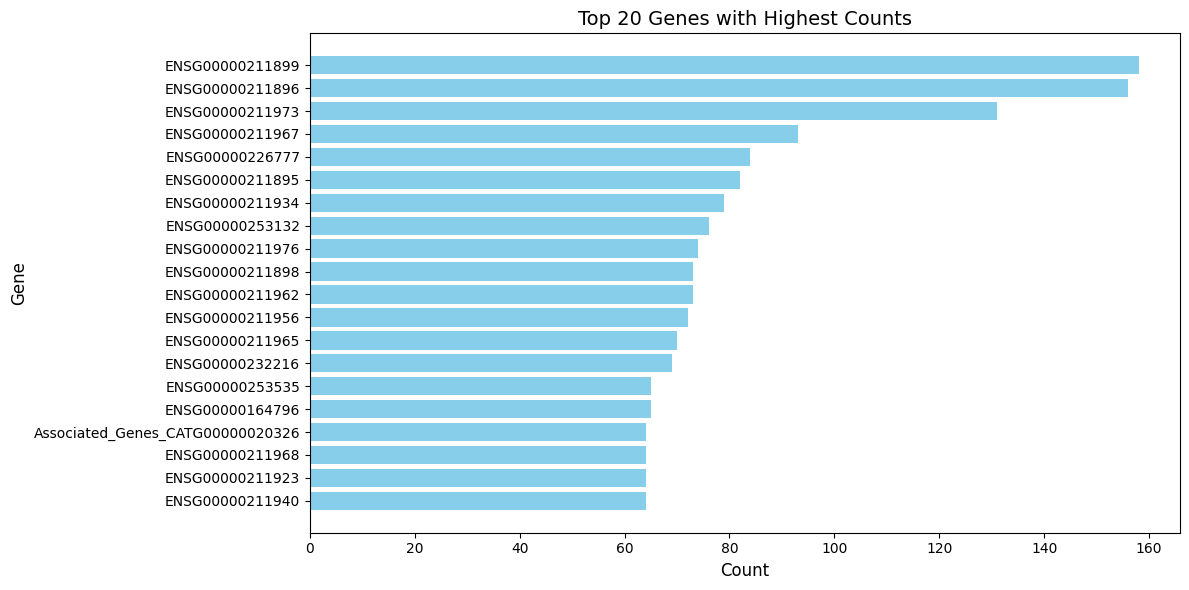

In [59]:
import matplotlib.pyplot as plt

# Plot the top 20 genes with the highest counts as a bar chart
top_genes = gene_counts_df.head(20)

plt.figure(figsize=(12, 6))
plt.barh(top_genes['Gene'], top_genes['Count'], color='skyblue')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Gene', fontsize=12)
plt.title('Top 20 Genes with Highest Counts', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count at the top
plt.tight_layout()
plt.show()